<a href="https://colab.research.google.com/github/csaybar/EarthEngineMasterGIS/blob/master/EXTRA/extra_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!--COURSE_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://user-images.githubusercontent.com/16768318/73986808-75b3ca00-4936-11ea-90f1-3a6c352766ce.png" width=10% >
<img align="right" style="padding-left:10px;" src="https://user-images.githubusercontent.com/16768318/73986811-764c6080-4936-11ea-9653-a3eacc47caed.png" width=10% >

**Bienvenidos!** Este *colab notebook* es parte del curso [**Introduccion a Google Earth Engine con Python**](https://github.com/csaybar/EarthEngineMasterGIS) desarrollado por el equipo [**MasterGIS**](https://www.mastergis.com/). Obten mas informacion del curso en este [**enlace**](https://www.mastergis.com/product/google-earth-engine-python/). El contenido del curso esta disponible en [**GitHub**](https://github.com/csaybar/EarthEngineMasterGIS) bajo licencia [**MIT**](https://opensource.org/licenses/MIT).

In [0]:
#@title Credenciales Google Earth Engine
import os 
credential = '{"refresh_token":"Ingrese_su_TOKEN_AQUI"}'
credential_file_path = os.path.expanduser("~/.config/earthengine/")
os.makedirs(credential_file_path,exist_ok=True)
with open(credential_file_path + 'credentials', 'w') as file:
    file.write(credential)

In [0]:
import ee
from pprint import pprint
ee.Initialize()

In [0]:
#@title mapdisplay: Crea mapas interactivos usando folium
import folium
def mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    center = center[::-1]
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

### **1. Componentes Principales (Teoría)**
**Fuente: Wikipedia**

En estadística, el análisis de componentes principales (en español ACP, en inglés, PCA) es una técnica utilizada para describir un conjunto de datos en términos de nuevas variables ("componentes") no correlacionadas. Los componentes se ordenan por la cantidad de varianza original que describen, por lo que la técnica es útil para reducir la dimensionalidad de un conjunto de datos.

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/f/f5/GaussianScatterPCA.svg" width=50%>
<br>
<caption> ACP de una distribución normal multivariante centrada en (1,3) con desviación estándar 3 en la dirección aproximada (0,866, 0,5) y desviación estándar 1 en la dirección perpendicular a la anterior. Los vectores muestran los autovectores de la matriz de correlación escalados mediante la raíz cuadrada del correspondiente autovalor, y desplazados para que su origen coincidan con la media estadística. </caption>
</center>

In [104]:
#@title PCA: ¿Como realmente funcionan?
from IPython.display import HTML
HTML('<center><iframe width="560" height="315" src="https://www.youtube.com/embed/FgakZw6K1QQ" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')

### **2. Implementacion en Google Earth Engine**

Esta funcion (**getPrincipalComponents**) necesita que el usuario ingrese:
  - Un objeto **ee.Image (centered)** con bandas de media espacial cero (esto es solo necesario para un calculo rapido de la covarianza).
  - La **escala (scale)** de la imagen.
  - Una **region (region)** en la que realizar el analisis.

El resultado son las componentes principales (PC) de la imagen en la region.


In [0]:
def getPrincipalComponents(centered, scale, region):
  # Convierta un objecto ee.Image a ee.Array()
  arrays = centered.toArray()
  # Calcule la covarianza de las bandas dentro de la region especificada
  covar = arrays.reduceRegion(
    reducer =  ee.Reducer.centeredCovariance(),
    geometry = region,
    scale = scale,
    maxPixels = 1e9
  )  
  # Recuerde que ña funcion *.reduceRegion siempre devolvera un ee.Dictionary.
  # Obtenga los resultados de covarianza almacenados en la llave 'array'.    
  covarArray = ee.Array(covar.get('array'))
  # Realice un eigen analysis y separe ('slice') los Eigenvector y los Eigenvalue.
  eigens = covarArray.eigen()
  # Separe solo el vector P-length de Eigenvalues.
  eigenValues = eigens.slice(1, 0, 1)  
  # Esta es una matrix de dimensiones PXP con Eigenvectors en las filas.
  eigenVectors = eigens.slice(1, 1)
  # Convierta nuestro array image de 1D a 2D para realizar operaciones a nivel de matrices (2D)
  arrayImage = arrays.toArray(1)
  # Multiplique nuestro image array (2D) por la matriz de Eigenvectors
  principalComponents = ee.Image(eigenVectors).matrixMultiply(arrayImage)  
  
  # Esta funcion crea una lista con nuevos nombres de banda.  
  def getNewBandNames(prefix):
    seq = ee.List.sequence(1, bandNames.length())
    return  seq.map(lambda b:ee.String(prefix).cat(ee.Number(b).toInt().format()))

  # Convierta las raices cuadradas de los Eigenvalues en una imagen P-band.
  sdImage = ee.Image(eigenValues.sqrt())\
              .arrayProject([0])\
              .arrayFlatten([getNewBandNames('sd')])
  # Calcule la varianza de cada CP a partir del eigen value
  eigenvalue_sum = eigenValues.reduce(ee.Reducer.sum(),[0]).get([0, 0])
  variance = eigenValues.divide(eigenvalue_sum).multiply(100)
  # Convierta las componenetes Principales en una imagen con bandas de longitud
  # banda P normalizada por SD.
  #   1. Deseche una dimensión innecesaria, [[]] -> [].
  #   2. Convierta el  array image de una banda en una imagen multibanda, [] -> imagen.
  #   3. Normalice las PC por sus SD.
  return (principalComponents\
          .arrayProject([0])\
          .arrayFlatten([getNewBandNames('pc')])\
          .divide(sdImage), variance.getInfo())

### **3. Ejemplo: Estima las componentes principales de una imagen Landsat-8**

In [0]:
# Cargue una imagen de Landsat 8, seleccione las bandas de interes.
image = ee.Image('LANDSAT/LC8_L1T/LC80440342014077LGN00')\
          .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11'])

In [171]:
# Muestra la imagen de entra y la region en la que se realiza el PCA.
center = image.geometry().centroid().coordinates().getInfo()
l8_viz = {'bands': ['B5', 'B4', 'B2'], 'min': 0, 'max': 20000}
mapdisplay(center, {'l8':image.getMapId(l8_viz)})

El centro medio de los datos permite un reductor de covarianza más rápido y un estiramiento SD de los componentes principales.

In [0]:
meanDict = image.reduceRegion(
    reducer = ee.Reducer.mean(),
    geometry = region,
    scale = scale,
    maxPixels = 1e9
)
means = ee.Image.constant(meanDict.values(bandNames))
centered = image.subtract(means)

**Obtenga las Componenetes Principales a la escala especificada y en la region especificada**

In [0]:
pcImage, img_variance = getPrincipalComponents(centered, scale = 30, region = centered.geometry())

**Cree un scree plot para visualizar la varianza de las componentes**

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def scree_plot(img_variance):
  variance = np.array(img_variance).flatten()#.cumsum()
  fig = plt.figure(figsize=(8,5))
  sing_vals = np.arange(num_vars) + 1
  plt.plot(sing_vals, variance, 'ro-', linewidth=2)
  plt.ylim(0, 115)
  plt.title('Scree Plot')
  plt.xlabel('Principal Component')
  plt.ylabel('Variance')
  leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
  leg.get_frame().set_alpha(0.4)
  plt.show()

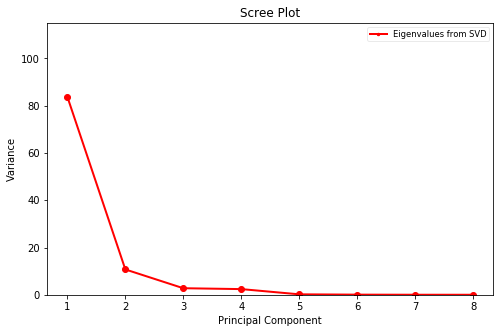

In [197]:
scree_plot(img_variance)

**Vizualize los resultados**

In [198]:
mapdisplay(center,{'pc':pcImage.select(['pc1','pc2','pc3']).getMapId({'min': -2, 'max': 2})})